In [6]:
%matplotlib inline
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import pandas as pd
from sctools import integrate, plot, io, annotate

## Integration of Tregs

In [2]:
# load data
prefixes = ['tcells.tissue.scps']
adatas = {}
for key in prefixes:
    adata = io.initialize_from_raw(f'../data/{key}.integrated.clustered.h5ad')
    key = key.replace('tcells', 'tregs')
    adatas[key] = adata[adata.obs.t_cell_types == 'Treg'].copy()
    del adata
    
adatas

/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


{'tregs.tissue.scps': AnnData object with n_obs × n_vars = 9781 × 20912
     obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types', 'leiden_scvi_0.4', 't_cell_types'}

In [3]:
# visualize raw data
for k, adata in adatas.items():
    print(k)
    plot.integrate.raw_data_umap(
        adata,
        ['status', 'sample_id', 'FOXP3', 'SAT1'],
        size = 10,
        vmax = 0.5,
        savefile = f'../plots/{k}.raw.umap.png'
    )

tregs.tissue.scps


/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/users/daniel.malzl/.local/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/users/daniel.malzl/.local/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/st

In [ ]:
# integrate tcells
integration_params = {
    f'tregs.{k}': {'kwargs': dict()} for k in adata.keys()
}

integration_results = {}
for key, adata in adatas.items():
    key = f'tregs..{key}'
    params = integration_params[key]
        
    print(key)
    integration_results[key] = integrate.integrate_data_scvi(
        adata.copy(),
        'sample_id',
        train_size = 1,
        **params['kwargs']
    )

    integration_results[key]['data'].write(
        f'../data/{key}.integrated.h5ad'
    )

    integration_results[key]['model'].save(
        f'../data/{key}.integration.scvi.model',
        overwrite = True
    )

In [4]:
# restore results if kernel breaks or gets shut down
integration_results = {}
for key in ['tregs.tissue.scps']:
    print(key)
    data = sc.read_h5ad(
        f'../data/{key}.integrated.h5ad'
    )
    integration_results[key] = {
        'data': data,
        'model': scvi.model.SCVI.load(
            f'../data/{key}.integration.scvi.model', 
            adata = data
        )
    }
integration_results

tregs.tissue.scps


/users/daniel.malzl/.conda/envs/scpython/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Trained

{'tregs.tissue.scps': {'data': AnnData object with n_obs × n_vars = 9773 × 20912
      obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types', 'leiden_scvi_0.4', 'dataset'
      uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'umap'
      obsm: 'X_scvi', 'X_umap'
      layers: 'counts'
      obsp: 'connectivities', 'distances',
  'model': }}

In [5]:
fig, axs = plot.integrate.plot_integration_results(
    integration_results,
    ['sample_id', 'status', 'FOXP3', 'SAT1'],
    [
        dict(size = 20, vmax = None),
        dict(size = 20, vmax = None),
        dict(size = 20, vmax = 1),
        dict(size = 20, vmax = 5)
    ],
    data_key = 'data',
    legend_off = True
)
fig.savefig('../plots/tregs.integration.results.png')

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are

## SAT1hi/lo annotation

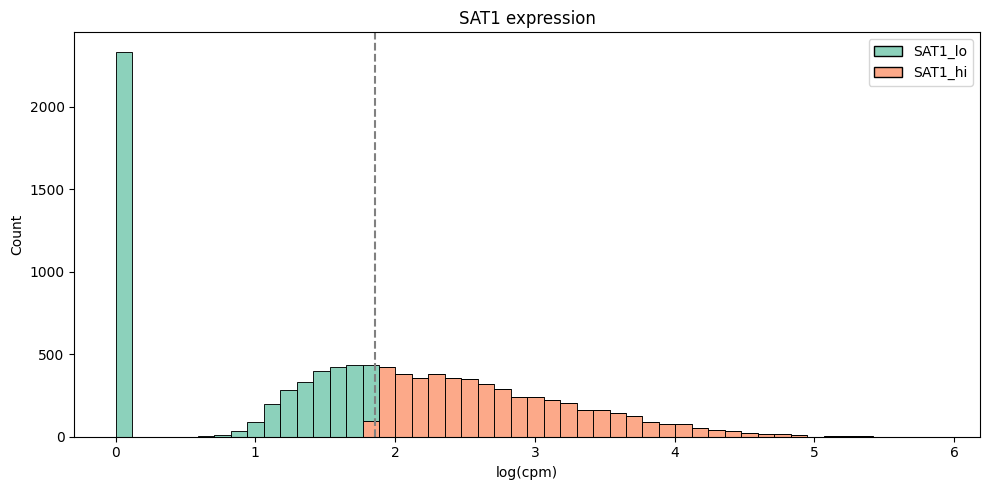

In [9]:
for k, d in integration_results.items():
    fig = plot.evaluate.plot_expression_histogram(
        d['data'],
        layer = 'counts'
    )
    fig.savefig(f'../plots/{k}.sat1.hist.pdf')

In [13]:
for k, d in integration_results.items():
    adata = d['data']
    adata.X = adata.layers['counts'].copy()
    sc.pp.normalize_total(
        adata,
        target_sum = 1e4
    )
    sc.pp.log1p(adata)
    annotate.annotate_adata_on_gene_hi_lo(adata, 'SAT1', 5)

/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


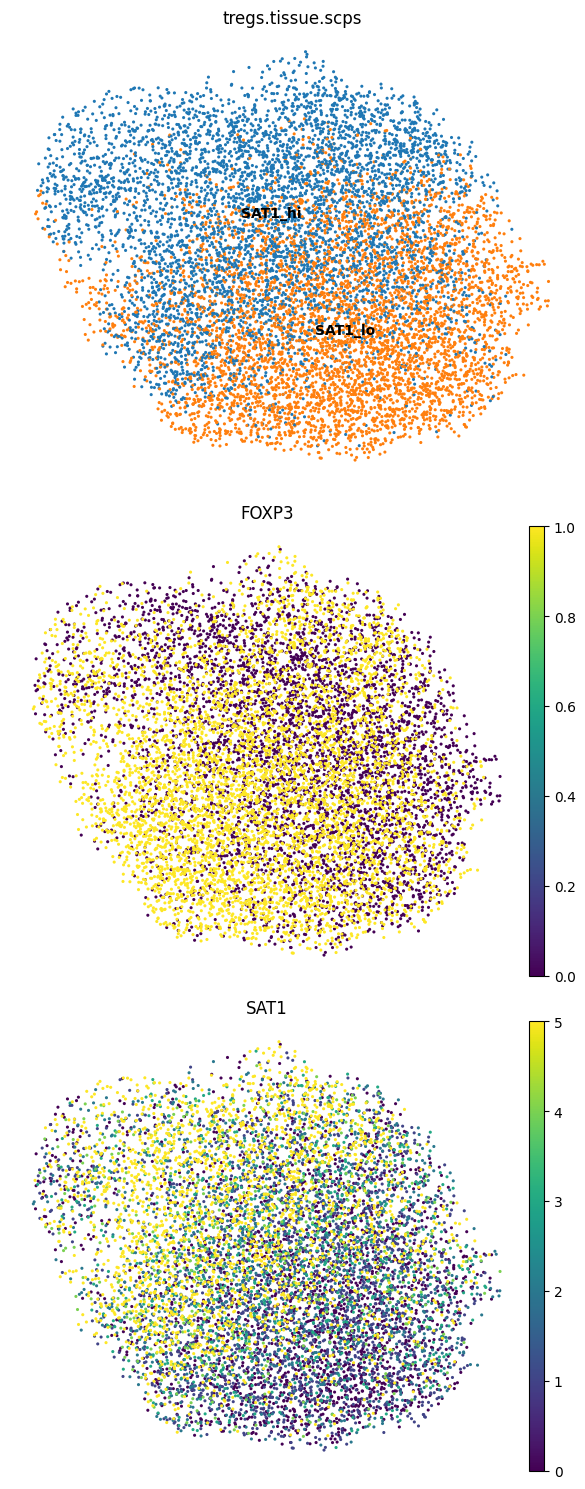

In [15]:
fig, axs = plot.integrate.plot_clustering_and_expression(
    integration_results,
    {k: 'sat1_status_majority_vote' for k in integration_results.keys()},
    ['FOXP3', 'SAT1'],
    [
        dict(size = 20, vmax = None, legend_loc = 'on data'),
        dict(size = 20, vmax = 1),
        dict(size = 20, vmax = 5)
    ],
    data_key = 'data'
)
fig.savefig('../plots/tregs.annotation.results.png')

In [16]:
for k, d in integration_results.items():
    d['data'].write(
        f'../data/{k}.integrated.annotated.h5ad'
    )

In [ ]:
for k, d in integration_results.items():
    adata = d['data']
    prefix = key + '.sat1'
    io.write_sc_data(
        adata[adata.obs.t_cell_types == 'Treg', :],
        '../diffexp/{prefix}',
        obs_columns = ['sample_id', 'status', 'sat1_status_majority_vote']
    )